# Shopify Subreddit LDA Topic Modelling

<img src="images/shopify-ipo-blog-banner.jpg" width="700">

## Introduction

The company I work for develops conversational Interactive Voice Response (IVR) which enables human-like interactions allowing individuals to self-serve and successfully resolve issues within the IVR. We all know that's not always the case - things change and issues become more complex. 

To anticipate customers' ever-changing needs for one of our clients, we have recently implemented an open-ended survey within the IVR to gather data on how the IVR failed to resolve their issues. The survey was conducted for two week and generated a sample of 2000 utterances. I then applied Latent Dirichlet Allocation (LDA), a topic modeling algorithm, to identify the underlying themes in the collected survey responses and were able to make practical recommendations to our client. 

Having gone through such exercise, I want to conduct a similar experiment with reddit's data to uncover common topics that Shopify merchants/users submit to reddit. 

## Importing Data from Shopify subreddit

First, I want to have an idea of the submissions volume of Shopify subreddit since 2016. To get data from reddit, I'll be using the [Python Pushshift.io API Wrapper](https://github.com/dmarx/psaw). 

In [3]:
import pandas as pd
import datetime as dt
from psaw import PushshiftAPI

In [4]:
api = PushshiftAPI()

In [5]:
import datetime as dt

start_epoch=int(dt.datetime(2017, 1, 1).timestamp())

subreddit = api.search_submissions(after=start_epoch,
                            subreddit='Shopify',
                            filter=['url', 'created', 'title']
                            )

topics_dict = { "title": [],"url":[], "created": []}

for submission in subreddit:
    topics_dict["title"].append(submission.title)
    topics_dict["url"].append(submission.url)
    topics_dict["created"].append(submission.created)

topics_data = pd.DataFrame(topics_dict)

#convert the date column from UNIX format to Gregorian format
def get_date(created):
    return dt.datetime.fromtimestamp(created)

_timestamp = topics_data["created"].apply(get_date)
topics_data = topics_data.assign(timestamp = _timestamp)

topics_data.to_csv('shopify_subreddit.csv', index=False)

In [10]:
%matplotlib notebook 
import matplotlib.pyplot as plt
topics_data.index = topics_data.timestamp
y_title_cnt = topics_data.title.resample('BMS', convention='start', how='count').values
x_title_cnt = topics_data.title.resample('BMS',convention='start', how='count').index

/Users/kenlam/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  after removing the cwd from sys.path.
/Users/kenlam/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  """


<IPython.core.display.Javascript object>


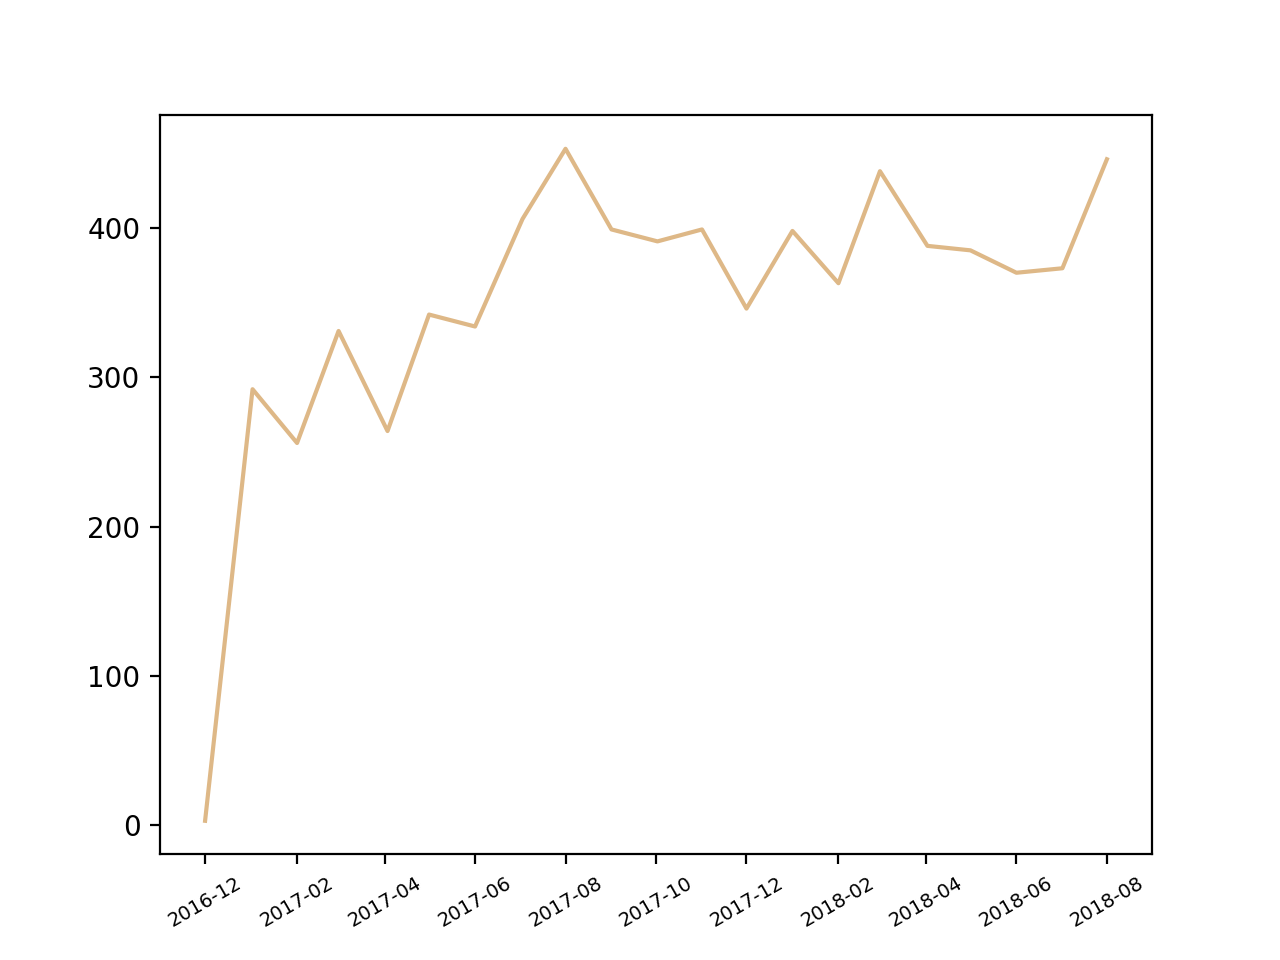

(array([736299., 736361., 736420., 736481., 736542., 736603., 736664.,
        736726., 736785., 736846., 736907.]),
 <a list of 11 Text xticklabel objects>)

In [11]:
width = 20
plt.plot(x_title_cnt,y_title_cnt, color = "burlywood")
plt.xticks(rotation=30, fontsize=7)

According to [Second-Quarter 2018 Financial Results](https://investors.shopify.com/Investor-News-Details/2018/Shopify-Announces-Second-Quarter-2018-Financial-Results/default.aspx), Subscription Solutions revenue grew 55%, driven primarily by an increase in the number of merchants joining the Shopify platform. I would expect that this increase in number of merchants would also induce a higher traffic in Shopify's subreddit, where Shopify merchants go to seek advice or share their experience. 

Looking at the chart above, it is obvious that the number of monthly submission in Shopify's subreddit has grown since 2017. What do they talk about? We may find out by fitting a Latent Dirichlet Allocation model to the data.

## Data Cleaning

In [124]:
df = pd.read_csv('shopify_subreddit.csv')

### Functions to Lemmatize & Tokenize

In [125]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
stemmer = PorterStemmer()
import nltk

In [126]:
keep_stopwords={'first'}
extra_stopwords = {'shopify'}
stopwords = STOPWORDS
new_stopwords = set(stopwords).difference(keep_stopwords)

def lemmatize_stemming(text):
    #return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
    return WordNetLemmatizer().lemmatize(text, pos='v')

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in new_stopwords and token not in extra_stopwords and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [127]:
documents = df.copy().dropna(subset=['title'])
documents.reset_index(drop=True, inplace=True)
documents.head()

,title,url,created,timestamp
0,Rate my shop please,https://www.reddit.com/r/shopify/comments/9bojhl/rate_my_shop_please/,1.535686e+09,2018-08-30 23:30:49
1,Has Shopify ever clarified why we can’t set individual shipping rates per item?,https://www.reddit.com/r/shopify/comments/9bnuu1/has_shopify_ever_clarified_why_we_cant_set/,1.535680e+09,2018-08-30 21:54:32
2,Cart button not linking to checkout upon adding item to cart [Debut theme],https://www.reddit.com/r/shopify/comments/9bmv8x/cart_button_not_linking_to_checkout_upon_adding/,1.535673e+09,2018-08-30 19:45:02
3,"Troubleshooting Website, Need Help",https://www.reddit.com/r/streetwearstartup/comments/9bkhho/troubleshooting_website_need_help/,1.535669e+09,2018-08-30 18:47:48
4,Message me of your interested in free personal mentoring on affiliate marketing :),https://www.reddit.com/r/shopify/comments/9bmalh/message_me_of_your_interested_in_free_personal/,1.535669e+09,2018-08-30 18:38:58


### Testing the Lemmatize & Tokenize Functions

In [128]:
doc_sample = documents[documents.index == 112].values[0][0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['How', 'to', 'find', 'out', 'which', 'theme', 'a', 'Shopify', 'store', 'is', 'using?']


 tokenized and lemmatized document: 
['theme', 'store']


### Lemmatize & Tokenize Subreddit's Titles

In [129]:
processed_docs = documents['title'].map(preprocess)

In [130]:
processed_docs.head(5)

0                                                      [rate, shop]
1                            [clarify, individual, ship, rat, item]
2     [cart, button, link, checkout, add, item, cart, debut, theme]
3                               [troubleshoot, website, need, help]
4    [message, interest, free, personal, mentor, affiliate, market]
Name: title, dtype: object

### Compute Bigrams

In [131]:
from gensim.models import Phrases

docs = list(processed_docs)
# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=2, threshold=10)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

/Users/kenlam/anaconda/envs/py3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


## Topic Model

### Create Dictionary

In [132]:
dictionary = gensim.corpora.Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=100000)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 30:
        break

0 rate
1 shop
2 item
3 rat
4 ship
5 ship_rat
6 add
7 button
8 cart
9 checkout
10 debut
11 debut_theme
12 link
13 theme
14 help
15 need
16 need_help
17 website
18 affiliate
19 free
20 interest
21 market
22 mentor
23 message
24 check
25 display
26 image
27 possible
28 order
29 work
30 first


### Create Corpus

In [133]:
corpus = [dictionary.doc2bow(text) for text in docs]

### Training the First LDA Model

In [669]:
NUM_TOPICS = 30
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=100)
#ldamodel.save('model.gensim')


In [670]:
topics = ldamodel.print_topics(num_words=5, num_topics=NUM_TOPICS)
for topic in topics:
    print(topic)

(0, '0.075*"collections" + 0.056*"show" + 0.054*"products" + 0.048*"year" + 0.046*"fulfillment"')
(1, '0.168*"sales" + 0.133*"order" + 0.126*"first" + 0.084*"shopify" + 0.063*"commerce"')
(2, '0.100*"custom" + 0.088*"shopify" + 0.077*"google" + 0.069*"post" + 0.056*"code"')
(3, '0.235*"best" + 0.078*"design" + 0.068*"shopify" + 0.061*"theme" + 0.056*"good"')
(4, '0.324*"free" + 0.081*"account" + 0.056*"fashion" + 0.033*"today" + 0.033*"style"')
(5, '0.147*"apps" + 0.107*"image" + 0.070*"shopify" + 0.067*"product" + 0.050*"easy"')
(6, '0.107*"sale" + 0.093*"guy" + 0.090*"think" + 0.090*"shopify" + 0.074*"check"')
(7, '0.248*"site" + 0.079*"shopify" + 0.071*"mobile" + 0.052*"review" + 0.050*"import"')
(8, '0.418*"store" + 0.305*"shopify" + 0.117*"sell" + 0.027*"products" + 0.014*"share"')
(9, '0.118*"traffic" + 0.103*"customers" + 0.065*"sales" + 0.056*"social" + 0.054*"shopify"')
(10, '0.092*"multiple" + 0.080*"setup" + 0.073*"conversion" + 0.064*"rate" + 0.059*"shopify"')
(11, '0.107*"

In [671]:
# Compute Coherence Score
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=ldamodel, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5444823399676727


### Optimize Coherence Score

In [99]:
# Plotting tools
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
%matplotlib inline

In [100]:
def compute_coherence_values_lda(dictionary, corpus, texts, limit, start=2, step=3, passes=300):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics = num_topics, id2word=dictionary, passes=passes)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

#### First run (50 topics to 600 topics)

In [101]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values_lda(dictionary=dictionary, corpus=corpus, texts=processed_docs, start=50, limit=650, step=50, passes=100)

/Users/kenlam/anaconda/envs/py3/lib/python3.6/site-packages/gensim/models/ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


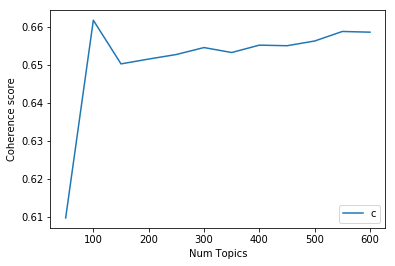

In [102]:
# Show graph
limit=650; start=50; step=50;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [113]:
max_score=max(coherence_values)
max_topic=x[coherence_values.index(max(coherence_values))]
print("Max coherence score of %s occurs at %s" %(max_score, max_topic))

Max coherence score of 0.6617168154120585 occurs at 100


After training the LDA model with different number of topics, it seems to suggest that the coherence score will keep increasing with higher number of topics. 

Intuitively, it's really hard to break documents into topics when we have short documents like reddit post titles; there isn't much room for anything but one topic in a title afterall. In my case, the extra number of topics most likely won't add anything to the classification; it might even do more harm than good. 

Considering that there was a significant jump at 100, so using 100 topics may be a good place to start. 

### Final Model

In [134]:
best_ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 100, id2word=dictionary, passes=500)

/Users/kenlam/anaconda/envs/py3/lib/python3.6/site-packages/gensim/models/ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [135]:
from gensim import models
# save trained model to file
best_ldamodel.save('lda.model')
# later on, load trained model from file
#best_ldamodel =  models.LdaModel.load('lda.model')

In [149]:
topics_best = best_ldamodel.print_topics(num_words=5, num_topics=20)
for topic in topics_best:
    print(topic)

(21, '0.440*"sales" + 0.097*"store" + 0.082*"fashion" + 0.071*"things" + 0.065*"support"')
(48, '0.364*"think" + 0.189*"tell" + 0.111*"real" + 0.106*"feel" + 0.096*"spend"')
(87, '0.231*"check" + 0.107*"users" + 0.094*"beginners" + 0.086*"brooklyn" + 0.079*"brooklyn_theme"')
(60, '0.681*"different" + 0.216*"supplier" + 0.000*"homepage" + 0.000*"value" + 0.000*"table"')
(27, '0.398*"traffic" + 0.169*"domain" + 0.077*"store" + 0.070*"canada" + 0.060*"company"')
(30, '0.877*"product" + 0.041*"slider" + 0.038*"actually" + 0.024*"store" + 0.000*"table"')
(18, '0.444*"design" + 0.163*"expert" + 0.095*"currently" + 0.094*"myshopify" + 0.089*"customize"')
(58, '0.792*"theme" + 0.080*"try" + 0.047*"wooden" + 0.025*"supply" + 0.024*"contact"')
(73, '0.244*"influencer" + 0.233*"messenger" + 0.231*"complete" + 0.167*"market" + 0.000*"value"')
(40, '0.634*"email" + 0.091*"email_market" + 0.084*"market" + 0.083*"relate" + 0.067*"notification"')
(80, '0.365*"good" + 0.184*"cost" + 0.124*"important" +

### Visualize the Final Model

In [187]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(best_ldamodel, corpus, dictionary, mds='mmds',sort_topics=True)
panel
#pyLDAvis.save_html(panel,'vis.html')

/Users/kenlam/anaconda/envs/py3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
86    -0.302919  0.369388       1        1  3.249508
78    -0.014195 -0.450633       2        1  2.295111
31    -0.449348 -0.266198       3        1  2.132956
90     0.529129  0.147628       4        1  2.053647
44     0.019309  0.545599       5        1  2.000128
49     0.265568 -0.250979       6        1  1.949864
21     0.117137 -0.314733       7        1  1.803530
58    -0.452909  0.245963       8        1  1.739787
39    -0.501690 -0.178532       9        1  1.689969
89     0.133831  0.524136      10        1  1.684648
99     0.242713  0.487501      11        1  1.630900
64    -0.187756  0.289394      12        1  1.512735
28    -0.310626  0.447021      13        1  1.477177
2      0.383061 -0.379444      14        1  1.361270
24     0.366793 -0.105270      15        1  1.356729
30    -0.399366 -0.265306      16        1  1.331306
75     0.068197 -0.451924      17        1  1.316595
85    -0.537051  0.071135      18        1  1.282743
77    -0.315464 -0.179478      19        1  1.265885
71    -0.145854  0.047121      20        1  1.260666
23     0.485683 -0.236264      21        1  1.246177
47     0.064869 -0.527109      22        1  1.242897
54     0.237254 -0.082104      23        1  1.225098
9      0.051398 -0.378751      24        1  1.174056
55    -0.417671  0.143081      25        1  1.171319
6     -0.130815  0.514253      26        1  1.146258
62     0.408721  0.348348      27        1  1.136985
22     0.404342 -0.291804      28        1  1.128191
32     0.193000  0.089103      29        1  1.117055
84     0.296573 -0.160681      30        1  1.094279
...         ...       ...     ...      ...       ...
5     -0.209765 -0.302240      71        1  0.727924
40    -0.078416 -0.516775      72        1  0.725202
48     0.165490 -0.228400      73        1  0.716755
61    -0.230694 -0.208322      74        1  0.711771
19     0.006993  0.069770      75        1  0.705706
36     0.180404 -0.488184      76        1  0.695872
26    -0.134086  0.426412      77        1  0.693431
92     0.074945  0.460732      78        1  0.688151
15    -0.149083 -0.427145      79        1  0.684753
37    -0.026216  0.491320      80        1  0.680918
33    -0.388150  0.342588      81        1  0.676884
41     0.047314  0.029670      82        1  0.661973
13     0.487575 -0.068512      83        1  0.658959
79     0.325926 -0.002186      84        1  0.643269
63     0.462978  0.206824      85        1  0.632283
98     0.406080 -0.201818      86        1  0.620297
65     0.405695  0.283551      87        1  0.619476
69    -0.305970 -0.291796      88        1  0.601033
34     0.196891  0.430396      89        1  0.588923
95    -0.059212  0.432458      90        1  0.586451
82     0.496861 -0.003368      91        1  0.582166
29     0.191865  0.011061      92        1  0.556677
93     0.102176  0.153503      93        1  0.547927
14     0.156279 -0.124054      94        1  0.497476
42     0.381319  0.219728      95        1  0.485864
38    -0.113041 -0.046200      96        1  0.471325
59    -0.181845  0.374148      97        1  0.418713
60    -0.318088  0.293887      98        1  0.407782
20    -0.395450 -0.129183      99        1  0.400026
73    -0.341939 -0.031957     100        1  0.375212

[100 rows x 5 columns], topic_info=      Category         Freq           Term        Total  loglift  logprob
term                                                                     
99     Default   453.000000         online   453.000000  30.0000  30.0000
14     Default   426.000000           help   426.000000  29.0000  29.0000
13     Default   376.000000          theme   376.000000  28.0000  28.0000
40     Default   356.000000        product   356.000000  27.0000  27.0000
19     Default   287.000000           free   287.000000  26.0000  26.0000
4      Default   285.000000           ship   285.000000  25.0000  25.0000
98

In [ ]:
The visualization can also be accessed by clicking [here]()

### Interpret the Top 5 Topics

In cases where we have relatively larger documents, printing a few documents that belong to each of the top 5 topics could help me to better interpret the topics. However, a lot of this data is in the form of short-text with just a handful of terms per document. This data is generally too sparse and noisy to obtain satisfactory classification. So instead of searching by the predominant topic, I will search by keywords instead. For example, topic no.1 is heavily weighted on the keywords "store" with some weight on the keywords "successful" and "talk". Search by those keywords gives us the following:

In [182]:
pd.set_option('max_colwidth', 100)
keyword_1 = documents.title.str.contains('help')
keyword_2 = documents.title.str.contains('need')
keyword_3 = documents.title.str.contains('store')
keyword_4 = documents.title.str.contains('love')
documents[(keyword_1) & (keyword_2|keyword_3|keyword_4)].title.head(30)

61                                                                                        I need title help
97      What are your favorite product research tools for Amazon or your online store that helps you dec...
192                                                                                    need help need help!
232                                                                          Shopify newbie in need of help
380                                                                 I need help, Which shopify app is this?
559                                                                                        I need some help
590                                                                  please help me, i need CSS assistance.
604                    50k this month so far on my shopify store...ask me your questions I am here to help!
643                                                I think a bot is trolling my Shopify store. Please help!
645                         

By looking at the results, topic no.1 is obviously about **store owners looking for help**.

Doing this exercise for the top 5 most predominant topics yields the following: 
1. Store owners looking for help
2. Use of analytics to identify best selling products and trending products
3. Product page, landing page and display options (e.g. position, color, etc) of product price
4. Description of a problem or questions related to click buttons
5. Dropshiping questions and how-to


## Conclusion

The accuracy of this topic modeling definitely requires further tuning and better data (i.e. larger documents), but it did offer a good start for data exploration. Several next steps that I would pursue in my next projects:

1. Dig deeper into the "need help" topic to see what are the common "help/advice" that merchants/users are looking for. 
2. Run a K-means clustering model with LDA results, as described by this [research article](http://wdsinet.org/Annual_Meetings/2016_Proceedings/papers/Paper45.pdf).
3. Train a new LDA model on the subreddit posts' bodies, which offer more content than the titles.
4. Analyze the topics of subreddit "reviewmyshopify" where Shopify merchants/users provides concrete advice/reviews on each other's store. 